In [63]:
import numpy as np
import pandas as pd

# Теория вероятностей

## 1. Базовые понятия

**Теория вероятностей** – математическая наука, позволяющая по вероятности одних случайных событий находить вероятности других случайных событий, связанных каким–либо образом между собой.  
Любой эксперимент имеет результат. В ТВ результат эксперимента – это **исход**.

Исход или группа исходов, удовлетворяющих определенным требованием, называется **событием**.

Например, если считать при броске кубика событием выпадение 1, а выпало 3, то событие не произошло.

In [90]:
np.random.randint(1, 7)

1

**Достоверное событие** – это такое событие, которое всегда происходит в рассматриваемом эксперименте.

**Невозможное событие** – это такое событие, которое никогда не может наступить в рассматриваемом эксперименте.

Событие, которое при воспроизведении опыта может наступить, а может и не наступить, называется **случайным событием**.

In [99]:
# Какое событие здесь будет невозможно, если моделируем бросок кубика?
np.random.randint(1, 6)

3

## Вероятностное пространство

Вероятностное пространство – $(\Omega, \Sigma, P)$

* $\Omega$ – произвольное непустое множество, элементы которого называются исходами  
* $\sigma$ - сигма-алгебра подмножеств $\Omega$ , называемых случайными событиями:
  * $\sigma$ содержит $\Omega$
  * Если $E \in \sigma$, то его дополнение $X \backslash E \in \sigma$
  * Объединение или пересечение подмножеств из $\Sigma$ принадлежит $\sigma$
* $P$ – вероятность, такая, что $P(\Omega) = 1$

**Вероятность** – степень возможности наступления события.

In [104]:
np.random.randint(0, 2, 100000000).mean()

0.5000003

In [147]:
number_of_rolls = 1000000
dice_rolls = np.random.randint(1, 7, number_of_rolls)
len(np.where(dice_rolls == 1)[0]) / number_of_rolls

0.167004

In [106]:
1/6

0.16666666666666666

### Дополнение, Объединение, Пересечение

Дополнение – есть событие $A$ с вероятностью $P(A)$ и событие $B = \Omega \backslash A$, тогда $P(B) = 1 - P(A)$

Объединение – $A \cup B$. Произошло либо $A$, либо $B$, либо $A$ и $B$ одновременно

Пересечение – $A \cap B$. Произошли одновременно $A$ и $B$

## 2. Условная вероятность

$P(A|B)$ – вероятность события $A$ при условии, что $B$ произошло

$$P(A|B) = \frac{P(A \cap B)}{P(B)}$$

In [122]:
data = pd.read_csv("./data.csv")

In [123]:
data

,company,model,rating,type
0,ford,mustang,A,coupe
1,chevy,camaro,B,coupe
2,ford,fiesta,C,sedan
3,ford,focus,A,sedan
4,ford,taurus,B,sedan
5,toyota,camry,B,sedan


In [53]:
rating_probs = data.groupby('rating').size().div(len(data))
rating_probs

rating
A    0.333333
B    0.500000
C    0.166667
dtype: float64

Посчитаем все условные вероятности для $P(rating|type)$

In [54]:
data.groupby(['type', 'rating']).size().div(len(data)).div(rating_probs, axis=0, level='rating')


type   rating
coupe  A         0.500000
       B         0.333333
sedan  A         0.500000
       B         0.666667
       C         1.000000
dtype: float64

In [58]:
data['count'] = 1
pivot = pd.pivot_table(
    data, 
    values='count', 
    index=['rating'], 
    columns=['type'], 
    aggfunc=np.size, 
    fill_value=0
)
pivot

type,coupe,sedan
rating,,
A,1,1
B,1,2
C,0,1


Посчитаем по pivot table условную вероятность для $P(A|coupe)$

In [56]:
(1/(1 + 1 + 1 + 2 + 1))/(1/3)

0.5

In [61]:
(pivot.loc['A', 'coupe']/(pivot.sum().sum())) / rating_probs['A']

0.5

## 3. Формула Байеса

$$P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}$$

Выводится из формулы условной вероятности:

$$P(A|B) = \frac{P(A \cap B)}{P(B)}$$
$$P(B|A) = \frac{P(B \cap A)}{P(A)}$$
$$P(A \cap B) = P(B \cap A) \implies$$
$$P(A \cap B) = P(A|B) \cdot P(B) = P(B|A) \cdot P(A) \implies$$
$$P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}$$

Поговорим про лекарства:  
Допустим, надо оценить вероятность того, что человек принимает лекарства (U – принимает, !U – не принимает)  
Тест может вернуть положительный или отрицательный результат (+ или -)

Допустим, наш тест имеет sensitivity 97% – из 100 человек тест будет True Positive у 97  
Допустим, наш тест имеет specificity 95% – из 100 человек тест будет True Negative у 95  
Также, мы знаем, что 0.5% нашего населения использует это лекарство (наш Prior)

Какая вероятность, что случайно взятый человек будет использовать лекарство?

$$P(U|+) = \frac{P(+|U) \cdot P(U)}{P(+)} = \frac{P(+|U) \cdot P(U)}{P(+|U) \cdot P(U) + P(+|!U) \cdot p(!U)}$$

$P(U) = распространенность \space (prevalence)$  
$P(!U) = 1 - P(U)$  
$P(+|U) = sensitivity$  
$P(-|!U) = specificity$  
$P(+|!U) = 1 - specificity$

In [124]:
def drug_user(
        sensitivity=0.97,
        specificity=0.95,
        prevalence=0.005):
    
    p_user = prevalence
    p_non_user = 1 - prevalence
    p_pos_user = sensitivity
    p_neg_user = specificity
    p_pos_non_user = 1 - specificity
    
    num = p_pos_user * p_user
    den = p_pos_user * p_user + p_pos_non_user * p_non_user
    
    prob = num/den
    
    return prob

In [128]:
drug_user(sensitivity=0.99, specificity=0.99, prevalence=0.005)

0.33221476510067094

Получается, даже при большой чувствительности и специфичности мы находим человека, использующего лекарство, при положительном тесте всего в 9% случаев

## 4. Случайные величины

### Матожидание и дисперсия

Математическое ожидание $E(X)$ – среднее значение случайной величины.

Дисперсия $D(X)$ – разброс случайной величины. Стандартное отклонение – корень из дисперсии.

In [129]:
data = np.random.randint(0, 10, 5000)

In [130]:
E = data.mean()
E

4.543

In [131]:
D = np.square(data.std())
D

8.194951000000001

### Функция распределения и плотность вероятности

Функция распределения (Cumulative Distribution Function, CDF): $F(x) = P(X \leq x)$  
Значение функции распределения в точке $x$ равно вероятности события ${X \leq x}$

Функция плотности вероятности (Probability Density Function, PDF): такая $f(X)$, что 
$$P(\xi \in [a, b]) = \int_a^b f(x)dx$$

То есть, можем получить вероятность события, взяв интеграл по функции распределения.

Вероятность того, что переменная попала в промежуток $[a, b]$ = $F(b) - F(a)$

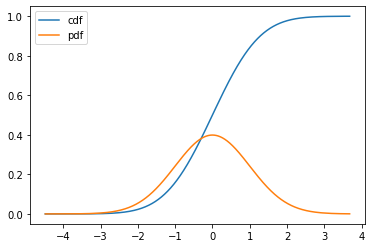

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

x = np.random.randn(10000) 
norm_cdf = scipy.stats.norm.cdf(x) 
norm_pdf = scipy.stats.norm.pdf(x) 

sns.lineplot(x=x, y=norm_cdf, label='cdf')
sns.lineplot(x=x, y=norm_pdf, label='pdf')
plt.show()

### Распределение среднего

Если мы возьмем случайные примеры ($X_1 .. X_n$) из выборки с $E = \mu$ и $D = \sigma^2$, то распределение следующей случайной величины будет нормальным: 
$$Z = \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt(n)}}$$
При $n \rightarrow \infty$  
Это называется Центральная Предельная Теорема

Матожидание 170.03
Стандартное отклонение 16.73


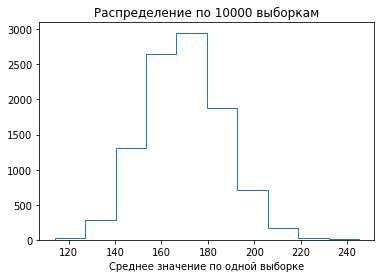

In [143]:
def repeat_sample_draws_exponential(n, samp_size, mu):
    means = []
    samples = []
    for i in range(0, n):
        samples.append(np.random.exponential(mu, samp_size))
        means.append(np.mean(samples[i]))

    plt.clf()
    plt.hist(means, bins=int(10), histtype='step')
    plt.title('Распределение по {} выборкам'.format(n))
    plt.xlabel('Среднее значение по одной выборке')
    print('Матожидание {0:.2f}'.format(np.mean(means)))
    print('Стандартное отклонение {0:.2f}'.format(np.std(means)))

repeat_sample_draws_exponential(10000, 100, 170)

$\sigma_{sample_mean} = \frac{\sigma_{population}}{\sqrt{sample_size}}$